In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils

from torch import nn, optim
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

IMG_SIZE = 96

In [ ]:
data_dir = Path('/content/drive/My Drive/Video J')
train_data = pd.read_csv(data_dir / 'key_training.csv')

In [ ]:
train_data.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7009,7010,7011,7012,7013,7014,7015,7016,7017,7018,7019,7020,7021,7022,7023,7024,7025,7026,7027,7028,7029,7030,7031,7032,7033,7034,7035,7036,7037,7038,7039,7040,7041,7042,7043,7044,7045,7046,7047,7048
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253,69.6807,64.1319,67.4689,65.8029,64.1212,65.2302,66.7376,66.5747,65.2706,66.6072,68.4913,66.6769,66.8504,67.8395,69.2335,65.5956,64.7625,66.0827,64.7186,66.3343,64.553,65.3184,65.4594,65.3769,72.3532,64.1556,64.9563,69.4418,67.5089,65.3781,66.0595,64.7125,66.215,67.0397,64.3325,...,66.6593,65.2627,66.3166,67.9037,66.4645,66.301,67.1193,64.8367,65.3903,62.3849,65.6084,61.9972,64.9061,67.0451,60.2021,72.2262,67.7241,63.0133,67.2779,65.84,69.4632,64.3929,67.3677,68.3209,66.162,66.6519,70.5049,71.2582,69.6162,64.6155,69.2299,63.353,65.7112,67.9293,66.8672,67.4025,66.1344,66.6907,70.9651,66.9383
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213,39.9687,34.29,39.4135,34.7552,36.7403,34.3426,39.8864,37.308,34.9402,38.9381,35.9002,33.9412,35.637,38.5979,40.0215,36.6264,34.9334,37.1537,35.8612,33.7213,36.5242,35.2704,38.9086,38.1289,34.4171,35.2538,35.2355,37.8516,35.7277,35.632,36.8486,34.2681,35.6378,32.372,34.6073,...,40.0731,36.2124,43.8757,41.7278,37.9797,35.7512,37.9044,35.2976,32.2801,32.2983,37.6214,37.2758,41.8102,41.7374,37.7435,40.0464,38.876,36.0536,37.3832,39.1238,41.0387,38.2252,38.0488,36.8326,35.9309,37.3327,35.7834,39.7446,38.0495,35.1653,38.5756,35.6713,38.8435,35.8466,37.3569,31.8426,38.3655,36.8452,39.8537,43.4245
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448,29.1836,29.579,29.356,27.4758,29.4689,28.8027,30.2704,30.4453,33.0227,28.5962,27.8312,30.7136,32.5281,28.0167,25.5508,31.5408,31.8597,27.9783,31.5907,29.0771,32.2198,30.3096,32.0514,29.2155,28.6554,30.7579,29.1167,28.6935,30.6683,30.191,26.5891,30.8571,30.4626,27.1397,32.8899,...,31.0751,29.3557,28.1583,34.0728,30.0619,30.8998,33.7967,31.2624,28.2914,32.7659,31.2643,31.4254,30.5803,29.8587,38.6491,33.0462,29.3992,28.7469,29.1766,29.494,33.8927,29.21,28.6823,29.1977,33.1005,29.2966,32.1823,33.4652,29.494,26.7072,29.4079,33.9521,32.2688,28.6878,30.7509,29.7467,30.4786,31.6664,30.5433,31.0961
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042,37.5634,33.138,39.6217,36.1856,38.3902,33.9378,38.8144,37.308,32.9769,36.3032,37.0221,36.1495,36.5246,36.3977,38.0719,39.3078,37.1915,37.436,39.1194,34.0977,38.0786,38.7026,39.2602,39.5589,32.828,35.2538,35.2355,35.6967,33.6292,34.3974,37.7069,32.2253,37.5031,32.372,37.2519,...,35.5442,42.2983,37.3487,38.4538,39.0829,36.8461,38.2101,40.0939,36.1694,40.8549,38.459,37.9127,36.566,38.177,37.4441,37.8698,37.9297,38.0497,40.6963,42.3241,41.8064,38.6517,37.8144,37.5662,34.9929,37.8341,39.0827,36.6878,42.5967,39.8279,38.3455,40.8164,37.706,41.4525,40.1157,38.6329,39.9502,39.685,40.7723,39.5286
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659,62.8643,57.7972,59.555,58.6522,58.6209,58.7538,61.0176,59.0362,60.5032,61.7145,62.3222,60.3671,61.2288,60.1393,60.2627,59.1474,59.9242,59.8731,59.2879,59.9368,58.4007,60.1705,59.8324,58.4306,63.8785,57.2384,59.201,62.585,61.2136,59.5131,60.0528,58.8754,59.9972,60.3898,59.6305,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213,40.1693,35.154,40.4548,37.3293,37.8406,35.5571,39.8864,38.2768,34.9402,38.9381,36.1807,35.2031,36.5246,39.698,40.0215,37.9068,35.9011,38.2828,37.762,34.8497,37.5387,36.2995,39.6119,39.3545,34.9467,36.1483,36.5438,38.2435,36.8932,36.558,37.7069,34.8519,36.5704,33.2301,35.4888,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.51

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In [ ]:
def show_keypoints(image, keypoints):
      
    plt.imshow(image, cmap='gray')
    if len(keypoints):
        plt.scatter(keypoints[:, 0], keypoints[:, 1], s=24, marker ='.', c='r')

In [ ]:
def show_images(df, indxs, ncols=5, figsize=(15,10), with_keypoints=True):

    plt.figure(figsize=figsize)
    nrows = len(indxs) // ncols + 1
    for i, idx in enumerate(indxs):
        image = np.fromstring(df.loc[idx, 'Image'], sep=' ').astype(np.float32).reshape(-1, IMG_SIZE)
        if with_keypoints:
            keypoints = df.loc[idx].drop('Image').values.astype(np.float32).reshape(-1, 2)
        else:
            keypoints = []
        plt.subplot(nrows, ncols, i + 1)
        plt.title(f'Sample #{idx}')
        plt.axis('off')
        plt.tight_layout()
        show_keypoints(image, keypoints)
    plt.show()

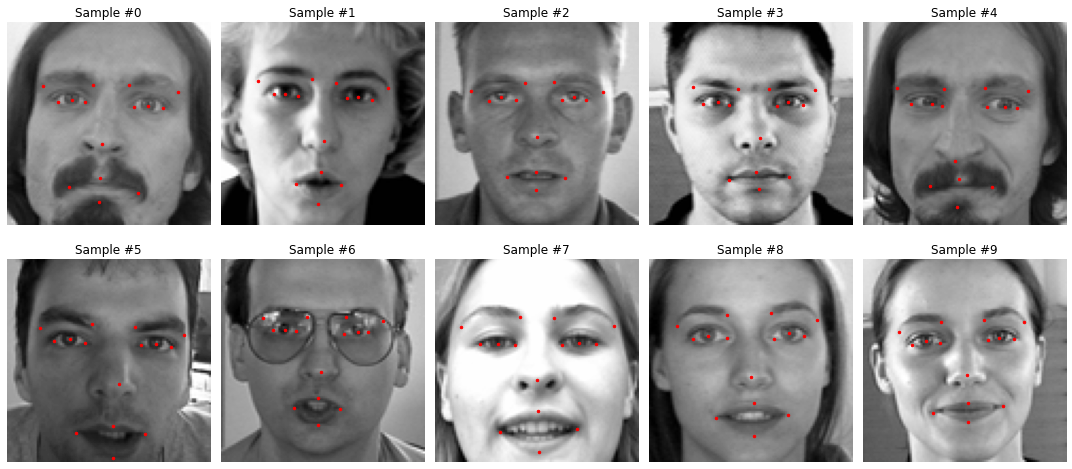

In [ ]:
show_images(train_data, range(10))

In [ ]:
test_data = pd.read_csv(data_dir / 'key_test.csv')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1783 entries, 0 to 1782
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImageId  1783 non-null   int64 
 1   Image    1783 non-null   object
dtypes: int64(1), object(1)
memory usage: 28.0+ KB


In [ ]:
test_data.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [ ]:
class FaceKeypointsDataset(Dataset):
    
    def __init__(self, dataframe, train=True, transform=None):

        self.dataframe = dataframe
        self.train = train
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        image = np.fromstring(self.dataframe.iloc[idx, -1], sep=' ')\
                .astype(np.float32).reshape(-1, IMG_SIZE)
        
        if self.train:
            keypoints = self.dataframe.iloc[idx, :-1].values.astype(np.float32)
        else:
            keypoints = None

        sample = {'image': image, 'keypoints': keypoints}
        
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

In [ ]:
class Normalize(object):
    
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        
        return {'image': image / 255., # scale to [0, 1]
                'keypoints': keypoints}
        
class ToTensor(object):

    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']

        image = image.reshape(1, IMG_SIZE, IMG_SIZE)
        image = torch.from_numpy(image)
        
        if keypoints is not None:
            keypoints = torch.from_numpy(keypoints)
            return {'image': image, 'keypoints': keypoints}
        else:
            return {'image': image}

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

def prepare_train_valid_loaders(trainset, valid_size=0.2, 
                                batch_size=128):

    num_train = len(trainset)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               sampler=train_sampler)
    valid_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               sampler=valid_sampler)
    
    return train_loader, valid_loader

In [ ]:
train_df = train_data.dropna()
test_df = test_data

batch_size = 128
valid_size = 0.2

tsfm = transforms.Compose([Normalize(), ToTensor()])

trainset = FaceKeypointsDataset(train_df, transform=tsfm)
testset = FaceKeypointsDataset(test_df, train=False, transform=tsfm)

train_loader, valid_loader = prepare_train_valid_loaders(trainset, 
                                                         valid_size,
                                                         batch_size)

test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

In [ ]:
from torch import nn, optim
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p =0.5):
        

        super(MLP, self).__init__()
        
        layer_sizes = [(input_size, hidden_layers[0])] \
                      + list(zip(hidden_layers[:-1], hidden_layers[1:]))
        self.hidden_layers = nn.ModuleList([nn.Linear(h1, h2) 
                                            for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(drop_p)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
            x = self.dropout(x)
        x = self.output(x)    
        return x

In [ ]:
model = MLP(input_size=IMG_SIZE*IMG_SIZE, output_size=30, 
            hidden_layers=[128, 64], drop_p=0.1)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [ ]:
def train(train_loader, valid_loader, model, criterion, optimizer, 
          n_epochs=50, saved_model='model.pt'):

    valid_loss_min = np.Inf

    train_losses = []
    valid_losses = []

    for epoch in range(n_epochs):
        train_loss = 0.0
        valid_loss = 0.0

        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            output = model(batch['image'].to(device))
            loss = criterion(output, batch['keypoints'].to(device))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*batch['image'].size(0)

        model.eval()
        for batch in valid_loader:
            output = model(batch['image'].to(device))
            loss = criterion(output, batch['keypoints'].to(device))
            valid_loss += loss.item()*batch['image'].size(0)

        train_loss = np.sqrt(train_loss/len(train_loader.sampler.indices))
        valid_loss = np.sqrt(valid_loss/len(valid_loader.sampler.indices))

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'
              .format(epoch+1, train_loss, valid_loss))

        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), saved_model)
            valid_loss_min = valid_loss
            
    return train_losses, valid_losses  

In [ ]:
train_losses, valid_losses = train(train_loader, valid_loader, model,
                                   criterion, optimizer, n_epochs=50, 
                                   saved_model='model.pt')

Epoch: 1 	Training Loss: 32.193685 	Validation Loss: 17.851130
Validation loss decreased (inf --> 17.851130).  Saving model ...
Epoch: 2 	Training Loss: 17.677878 	Validation Loss: 13.029483
Validation loss decreased (17.851130 --> 13.029483).  Saving model ...
Epoch: 3 	Training Loss: 15.118968 	Validation Loss: 12.181699
Validation loss decreased (13.029483 --> 12.181699).  Saving model ...
Epoch: 4 	Training Loss: 13.810398 	Validation Loss: 11.876671
Validation loss decreased (12.181699 --> 11.876671).  Saving model ...
Epoch: 5 	Training Loss: 13.599433 	Validation Loss: 11.710878
Validation loss decreased (11.876671 --> 11.710878).  Saving model ...
Epoch: 6 	Training Loss: 12.974278 	Validation Loss: 11.287662
Validation loss decreased (11.710878 --> 11.287662).  Saving model ...
Epoch: 7 	Training Loss: 12.467292 	Validation Loss: 11.193707
Validation loss decreased (11.287662 --> 11.193707).  Saving model ...
Epoch: 8 	Training Loss: 12.041722 	Validation Loss: 13.373725
Epoch

In [ ]:
def plot_RMSE(train_losses, valid_losses, y_max=50):
    plt.plot(train_losses, "--", linewidth=3, label="train")
    plt.plot(valid_losses, linewidth=3, label="val")
    plt.legend()
    plt.grid()
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.ylim((0, y_max))
    plt.show()

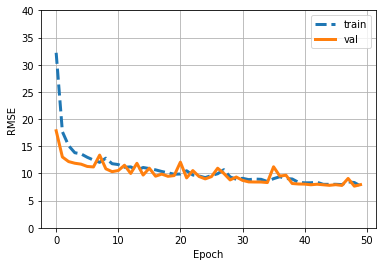

In [ ]:
plot_RMSE(train_losses, valid_losses, y_max=40)

In [ ]:
model = torch.load('model.pt')